# Dataset: Cattle Prices
Weekly Price c/kg Lwt of SELX Yass saleyard from https://www.mla.com.au/prices-markets/statistics/cattle-transactions/
lwt: Liveweight – the weight of a live animal. 
Glossary of terms: https://www.mla.com.au/general/glossary

<AxesSubplot:xlabel='Date'>

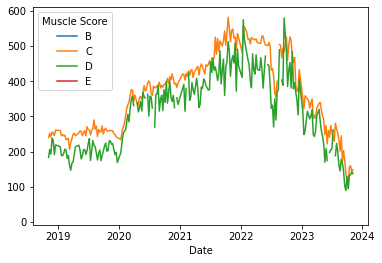

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

data = pd.read_csv(r"MLA_nlrs_cattle_transactions_report_20231103.csv", skiprows=5)
# data.head(5)
# data.dtypes
data['Weekly'] = pd.to_datetime(data['Weekly'])
data['Date'] = data['Weekly'].dt.date
data.head(5)
# I'm keeping only 'Yearling Heifer' to simplify the model for now
data = data.loc[data['Category'] == 'Yearling Heifer']
data.head(5)
# Muscle score is an inditication of build/weight of the cattle
df = data.groupby(['Date', 'Muscle Score'])['Price c/kg Lwt'].mean()
df = df.unstack(level='Muscle Score')
# df.head(10)
df.plot()

### General Analysis Steps 

1. Do we need to scale the data? *Yes, looks like the degree of variation is not constant over time*
2. Fit (non)linear trend to the data? *Yes, looks like there's a trend to the data* 
3. Fit seasonal components?
4. Fit external regressors? 
5. Fit AR/MA model? 

### Transforming data
Here, the variance of the data is not constant over time. 
This violates one of the assumptions of stationarity.
We can correct by taking a log transformation of the data - now, the variance looks more consistent over the time series. 

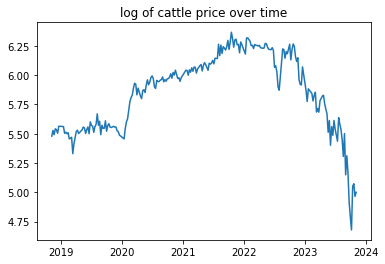

In [87]:
# I'm going to work with Muscle Score 'C' as it is the medium weight and we have almost full data
df.head(10)
c = df[df['C'].notna()]['C']
price = c.to_numpy().reshape(-1, 1)
price
date = c.index.to_numpy().reshape(-1, 1)
date

# Applying log transformation
log_price = np.log(price)
plt.plot(date, log_price)
plt.title("log of cattle price over time")
plt.show()

#### Information Criteria


Idea: find a balance between model fit and complexity. 

AIC (Akaike Information Criteria): $-2 * \text{log-likelihood} + 2k$ 

BIC (Bayesian Information Criteria): $-2 * \text{log-likelihood} + k \log(n)$ 

where $k$ is the model complexity (degrees of freedom used up) and $n$ is the number of elements. 

A good practice is to select a model that minimizes both of these criteria; when they disagree, turn to another approach like out-of-sample validation. 

In [88]:
# Example here about how to find; what my assumption is behind this 
from scipy.stats import norm 
def evaluate_AIC(k, residuals):
  """
  Finds the AIC given the number of parameters estimated and 
  the residuals of the model. Assumes residuals are distributed 
  Gaussian with unknown variance. 
  """
  standard_deviation = np.std(residuals)
  log_likelihood = norm.logpdf(residuals, 0, scale=standard_deviation)
  return 2 * k - 2 * np.sum(log_likelihood)
def evaluate_BIC(k, residuals):
  """
  Finds the AIC given the number of parameters estimated and 
  the residuals of the model. Assumes residuals are distributed 
  Gaussian with unknown variance. 
  """
  standard_deviation = np.std(residuals)
  log_likelihood = norm.logpdf(residuals, 0, scale=standard_deviation)
  return k * np.log(len(residuals)) - 2 * np.sum(log_likelihood)

### Start with a linear model: 

[[0.00085478]]


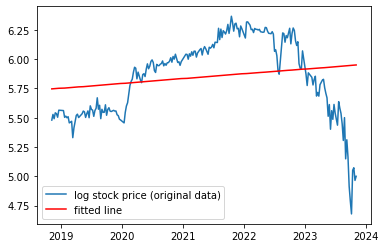

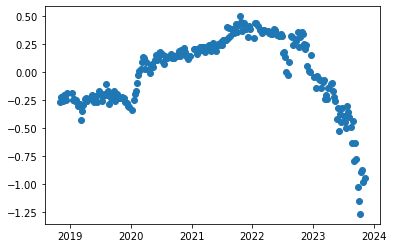

MSE with linear fit: 0.10637619442223634
AIC: 145.30486464052663
BIC: 148.78550356386862


In [89]:
from sklearn import linear_model

index = c.reset_index().index.values.reshape(-1,1)
index

clf = linear_model.LinearRegression()
clf.fit(index, log_price)
print(clf.coef_) # To print the coefficient estimate of the series. 
linear_prediction = clf.predict(index)
plt.plot(date, log_price, label='log stock price (original data)')
plt.plot(date, linear_prediction, 'r', label='fitted line')
plt.legend()
plt.show()
linear_residuals = log_price - linear_prediction
plt.plot(date, linear_residuals, 'o')
plt.show();
print("MSE with linear fit:", np.mean((linear_residuals)**2))
print("AIC:", evaluate_AIC(1, linear_residuals))
print("BIC:", evaluate_BIC(1, linear_residuals))

### After linear fit, it seems like a higher order model is needed

[[ 1.62214748e-02 -6.42957995e-05]]


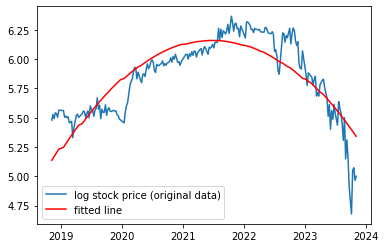

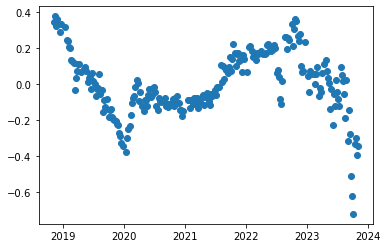

MSE with quadratic fit: 0.030185845270924376
AIC: -155.00122344901817
BIC: -148.0399456023342


In [90]:
## After linear fit, it seems like a higher order model is needed

new_x = np.hstack((index, index **2))
clf.fit(new_x, log_price)
print(clf.coef_) # To print the coefficient estimate of the series. 
quad_prediction = clf.predict(new_x)
plt.plot(date, log_price, label='log stock price (original data)')
plt.plot(date, quad_prediction, 'r', label='fitted line')
plt.legend()
plt.show()
quad_residuals = log_price - quad_prediction
plt.plot(date, quad_residuals, 'o')
plt.show();
print("MSE with quadratic fit:", np.mean((quad_residuals)**2))
print("AIC:", evaluate_AIC(2, quad_residuals))
print("BIC:", evaluate_BIC(2, quad_residuals))

[[-3.19393683e-03  1.39218855e-04 -5.67683835e-07]]


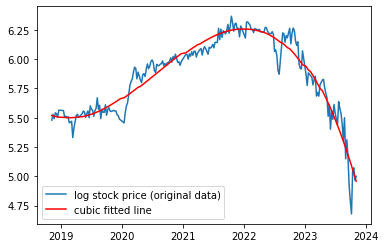

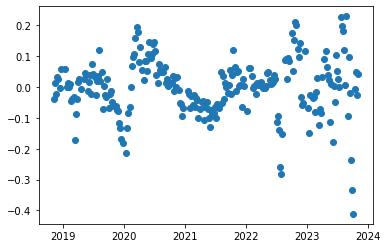

MSE with cubic fit: 0.008196266463929873
AIC: -467.88787310340103
BIC: -460.92659525671706


In [91]:
## Let's have a look at the 3rd order model as well

cube_x = np.hstack((index, index **2, index **3))
clf.fit(cube_x, log_price)
print(clf.coef_) # To print the coefficient estimate of the series. 
cube_prediction = clf.predict(cube_x)
plt.plot(date, log_price, label='log stock price (original data)')
plt.plot(date, cube_prediction, 'r', label='cubic fitted line')
plt.legend()
plt.show()
cube_residuals = log_price - cube_prediction
plt.plot(date, cube_residuals, 'o')
plt.show();
print("MSE with cubic fit:", np.mean((cube_residuals)**2))
print("AIC:", evaluate_AIC(2, cube_residuals))
print("BIC:", evaluate_BIC(2, cube_residuals))

### Cubic fit looks like a satisfactory model for the trend 

## Examine ACF/PACF

This tells us about existence of periodic components, or AR/MA models. 

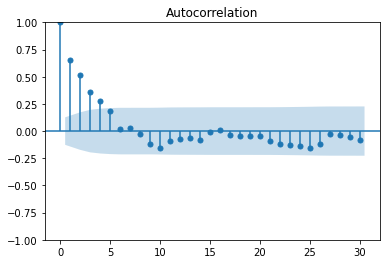

C:\Users\secil\anaconda3\envs\Data Analysis\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


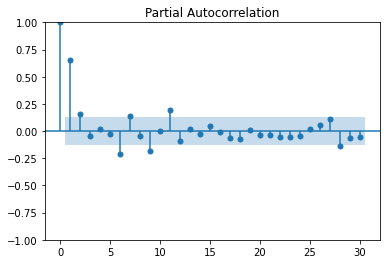

In [92]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(cube_residuals, lags=30)
plt.show()
sm.graphics.tsa.plot_pacf(cube_residuals, lags=30)
plt.show()

## Interpretation: 
After taking a log transformation of the data, and removing a quadratic trend, there's a pattern in the ACF/PACF plots. Strong first term in PACF, exponentially decaying ACF which is an evidence of an AR(1) component. We can confirm by doing a grid search over possible values: 


It's important to model these terms, because AR/MA can change the error structure, if analysis of coefficients is important. It can also change how we make forecasts, and our confidence bands on those forecasts. 

In [93]:
from statsmodels.tsa.arima.model import ARIMA

def grid_search_ARIMA(data, AR_range, MA_range, verbose=False):
  min_aic = np.inf 
  min_bic = np.inf
  min_aic_index = None
  min_bic_index = None 
  aic_matrix = np.zeros((len(AR_range), len(MA_range)))
  bic_matrix = np.zeros((len(AR_range), len(MA_range)))
  for AR_order in AR_range:
    for MA_order in MA_range:
      arma = ARIMA(data, order=(AR_order, 0, MA_order)).fit()
      aic_matrix[AR_order, MA_order] = arma.aic
      bic_matrix[AR_order, MA_order] = arma.bic
      if arma.aic < min_aic:
        min_aic = arma.aic
        min_aic_index = (AR_order, 0, MA_order)
      if arma.bic < min_bic:
        min_bic = arma.bic
        min_bic_index = (AR_order, 0, MA_order)
  if verbose:
    print("Minimizing AIC order: ", min_aic_index)
    print("Minimizing BIC order: ", min_bic_index )
    print("matrix of AIC", aic_matrix)
    print("Matrix of BIC", bic_matrix)
  return min_aic_index, min_bic_index, aic_matrix, bic_matrix

In [94]:
min_aic_index, min_bic_index, _, _ = grid_search_ARIMA(cube_residuals, range(4), range(4), verbose=True)
if min_aic_index == min_bic_index:
  arma = ARIMA(cube_residuals, order=min_bic_index).fit()
  print(arma.summary())
  arma_predictions = arma.predict().reshape(-1,1)
  arma_residuals = cube_residuals - arma_predictions
#   arma_residuals = arma_residuals # Fitting AR 1 model means removing one observation
  plt.plot(cube_residuals, label='Residuals from fitted cubic line')
  plt.plot(arma_predictions, 'r', label='fitted ARMA process')
  plt.legend()
  plt.show()
  plt.plot(arma_residuals, 'o')
  plt.show()
  print("Automatic selection finds model with AR {0}, MA {2}".format(*min_aic_index))
  print("MSE with selected model:", np.mean(arma_residuals**2))
else:
  print("AIC, BIC do not agree.")

C:\Users\secil\anaconda3\envs\Data Analysis\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\secil\anaconda3\envs\Data Analysis\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\secil\anaconda3\envs\Data Analysis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Minimizing AIC order:  (3, 0, 3)
Minimizing BIC order:  (1, 0, 0)
matrix of AIC [[-467.8878709  -547.09472389 -591.54738522 -590.37024185]
 [-600.17249426 -602.77297101 -601.73238999 -599.97377573]
 [-603.58775897 -602.09077301 -600.14559865 -598.61649251]
 [-602.08573398 -600.12449746 -609.35670226 -609.7137077 ]]
Matrix of BIC [[-460.92659305 -536.65280712 -577.62482952 -572.96704724]
 [-589.73057749 -588.85041532 -584.32919537 -579.08994219]
 [-589.66520328 -584.68757839 -579.26176511 -574.25202005]
 [-584.68253937 -579.24066392 -584.9922298  -581.86859631]]
AIC, BIC do not agree.


C:\Users\secil\anaconda3\envs\Data Analysis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Evaluate with Test Set

Here, we see how well this predicts future values; we set an arbitrary value of 20% of the series. In practice, you would likely use rolling windows to assess the performance more credibly, since 20% of the series can actually be much further than the model predicts. 

An illustration of rolling windows: for $t = 1, \dots, 100$, train a model on steps $t = 1, \dots, 20$, then predict on $t = 21, \dots, 40$. Then train the model on $t = 1, \dots, 40$ and predict on $t = 41, \dots, 60$, and so on.

In [95]:
train_test_split = int(len(price) * 0.8)
train_price, test_price = cube_residuals[:train_test_split], cube_residuals[train_test_split:]
train_date, test_date = date[:train_test_split], date[train_test_split:]
assert(len(train_date) + len(test_date) == len(date))

C:\Users\secil\anaconda3\envs\Data Analysis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  192
Model:                 ARIMA(3, 0, 3)   Log Likelihood                 308.704
Date:                Mon, 06 Nov 2023   AIC                           -601.408
Time:                        11:44:29   BIC                           -575.348
Sample:                             0   HQIC                          -590.853
                                - 192                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.019      0.174      0.862      -0.034       0.040
ar.L1          1.1972      0.082     14.516      0.000       1.036       1.359
ar.L2         -1.2209      0.103    -11.852      0.0

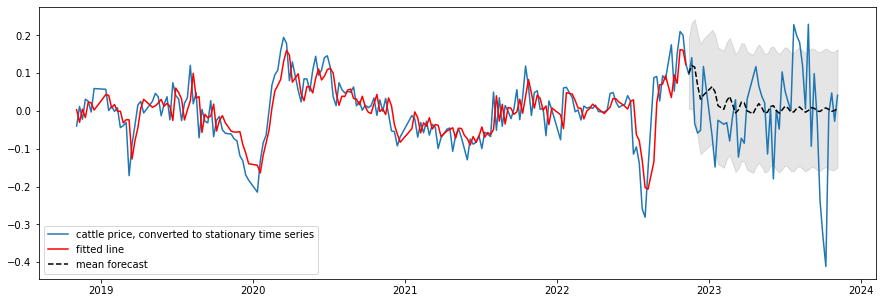

In [96]:
## First, let's see how this does with the AIC selected model. 
arma = ARIMA(train_price, order=min_aic_index).fit()
print(arma.summary())
fig, ax = plt.subplots(figsize=(15, 5))

# Construct the forecasts
fcast = arma.get_forecast(len(test_price)).summary_frame()

arma_predictions = arma.predict()
ax.plot(date, cube_residuals, label='cattle price, converted to stationary time series')
predicted_values = arma_predictions.reshape(-1,1)
ax.plot(train_date, predicted_values, 'r', label='fitted line')
forecast_means = fcast['mean'].values.reshape(-1,1)
test_set_mse = np.mean((forecast_means.reshape(test_price.shape) - test_price)**2)
ax.plot(test_date, forecast_means, 'k--', label='mean forecast')
ax.fill_between(test_date.flatten(), fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);
plt.legend();
print("Test set mean squared error: ", test_set_mse)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  192
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 302.644
Date:                Mon, 06 Nov 2023   AIC                           -599.288
Time:                        11:52:04   BIC                           -589.516
Sample:                             0   HQIC                          -595.330
                                - 192                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.017      0.151      0.880      -0.030       0.035
ar.L1          0.7791      0.037     20.785      0.000       0.706       0.853
sigma2         0.0025      0.000     12.551      0.0

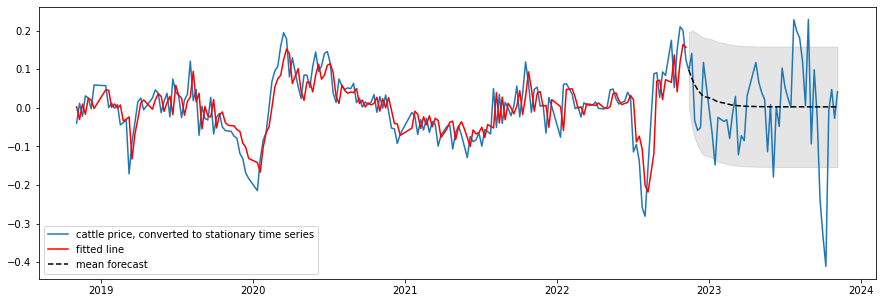

In [104]:
## Let's see how this does with the BIC selected model. 
arma = ARIMA(train_price, order=min_bic_index).fit()
print(arma.summary())
fig, ax = plt.subplots(figsize=(15, 5))

# Construct the forecasts
fcast = arma.get_forecast(len(test_price)).summary_frame()

arma_predictions = arma.predict()
ax.plot(date, cube_residuals, label='cattle price, converted to stationary time series')
predicted_values = arma_predictions.reshape(-1,1)
ax.plot(train_date, predicted_values, 'r', label='fitted line')
forecast_means = fcast['mean'].values.reshape(-1,1)
test_set_mse = np.mean((forecast_means.reshape(test_price.shape) - test_price)**2)
ax.plot(test_date, forecast_means, 'k--', label='mean forecast')
ax.fill_between(test_date.flatten(), fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);
plt.legend();
print("Test set mean squared error: ", test_set_mse)

BIC selected first order (1,0,0) produces a slighly smaller MSE in the test set - I will go ahead with that model order

### But what does the final prediction look like?
I think I will need to combine all predictions and compare it to the actuals

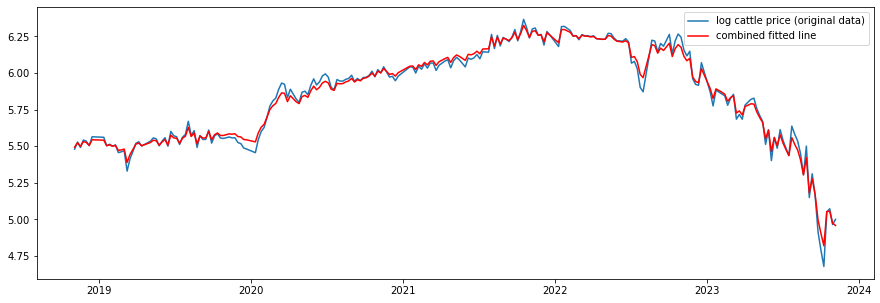

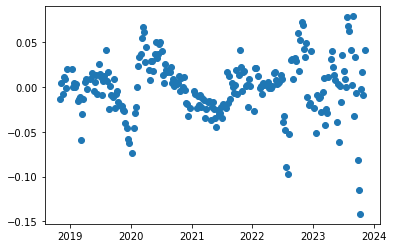

MSE with log transformed model: 0.0009782093744079717


In [105]:
arma_all = ARIMA(cube_residuals, order=(1,0,0)).fit()
arma_all_predictions = arma_all.predict().reshape(-1,1)
# arma_all_predictions
# cube_prediction

#Shifted the prediction 1 value to the left to compansate for the arma model order
arma_all_predictions_shifted = np.append(arma_all_predictions[1:], [0]).reshape(-1,1)
# arma_all_predictions
final_log_prediction = arma_all_predictions_shifted + cube_prediction

fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(date, log_price, label='log cattle price (original data)')
plt.plot(date, final_log_prediction, 'r', label='combined fitted line') 
plt.legend()
plt.show()
final_log_residuals = log_price - final_log_prediction
plt.plot(date, final_log_residuals, 'o')
plt.show();
print("MSE with log transformed model:", np.mean((final_log_residuals)**2))

Final result after un-doing the log transformation

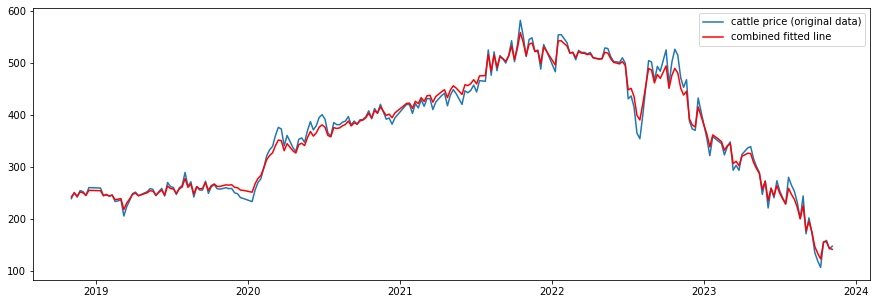

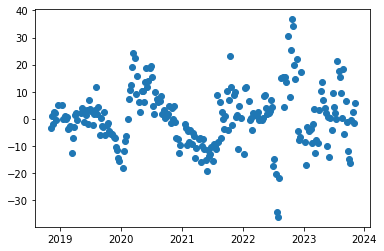

MSE of the final model: 111.68935428910997


In [106]:
final_prediction = np.exp(final_log_prediction)
final_residuals = price - final_prediction

fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(date, price, label='cattle price (original data)')
plt.plot(date, final_prediction, 'r', label='combined fitted line') 
plt.legend()
plt.show()
plt.plot(date, final_residuals, 'o')
plt.show();
print("MSE of the final model:", np.mean((final_residuals)**2))

What would the model predict for 4 weeks into the future (from when the data ends)?

In [107]:
arma_forecast = arma_all.forecast(steps=4).reshape(-1,1)
arma_forecast

index = c.reset_index().index.values.reshape(-1,1)
index_forecast = np.append(index, [index[-1]+1, index[-1]+2, index[-1]+3, index[-1]+4]).reshape(-1,1)

In [108]:
date = np.array(c.index.to_numpy().reshape(-1, 1), dtype='datetime64')
date_forecast = np.append(date, pd.date_range(start=c.index[-1], periods=5, inclusive='right', freq='w')).reshape(-1,1)

date_forecast

array([['2018-11-04T00:00:00.000000000'],
       ['2018-11-11T00:00:00.000000000'],
       ['2018-11-18T00:00:00.000000000'],
       ['2018-11-25T00:00:00.000000000'],
       ['2018-12-02T00:00:00.000000000'],
       ['2018-12-09T00:00:00.000000000'],
       ['2018-12-16T00:00:00.000000000'],
       ['2019-01-13T00:00:00.000000000'],
       ['2019-01-20T00:00:00.000000000'],
       ['2019-01-27T00:00:00.000000000'],
       ['2019-02-03T00:00:00.000000000'],
       ['2019-02-10T00:00:00.000000000'],
       ['2019-02-17T00:00:00.000000000'],
       ['2019-02-24T00:00:00.000000000'],
       ['2019-03-03T00:00:00.000000000'],
       ['2019-03-10T00:00:00.000000000'],
       ['2019-03-17T00:00:00.000000000'],
       ['2019-03-24T00:00:00.000000000'],
       ['2019-03-31T00:00:00.000000000'],
       ['2019-04-07T00:00:00.000000000'],
       ['2019-04-14T00:00:00.000000000'],
       ['2019-05-05T00:00:00.000000000'],
       ['2019-05-12T00:00:00.000000000'],
       ['2019-05-19T00:00:00.00000

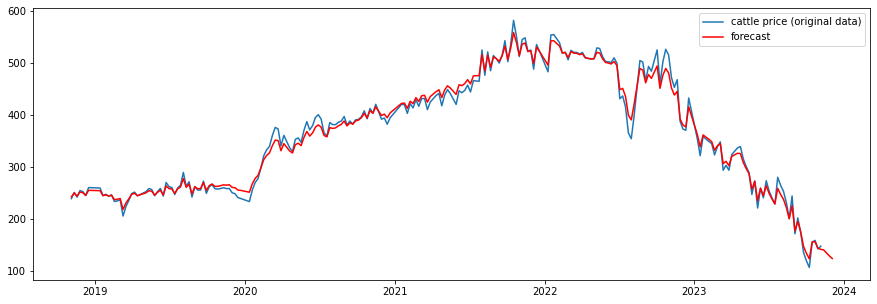

In [109]:
forecast_x = np.hstack((index_forecast, index_forecast **2, index_forecast **3))
# clf.fit(forecast_x, log_price)
# print(clf.coef_) # To print the coefficient estimate of the series. 
cube_forecast = clf.predict(forecast_x)
log_forecast = np.append(arma_all_predictions_shifted, [arma_forecast]).reshape(-1,1) + cube_forecast
forecast = np.exp(log_forecast)

fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(date, price, label='cattle price (original data)')
plt.plot(date_forecast, forecast, 'r', label='forecast') 
plt.legend()
plt.show()

### Further investigations
- Seasonality? From PACF plot it didn't look like there is strong seasonality but Deb suggested there is a decline around Xmas and Easter
- External regressor? Should I incorporate the number of animals sold in the regression?

I tried to export the data to put on a dashboard but excel is not interpreting the data formats properly and I couldn't find a way to format the output. So copy & paste'ing it is!

In [102]:
# export = np.asarray(np.hstack((date_forecast.squeeze(), forecast.squeeze())), dtype = 'object')
# export = np.hstack((date_forecast.squeeze(), forecast.squeeze()))
# export

# forecast[0:].shape
# np.savetxt('price_forecast.csv', np.reshape((np.array(date_forecast.squeeze(), dtype='datetime64'), np.array(forecast.squeeze(), dtype='float')), (-1,2)), delimiter=','
#            , header='Date,Predicted_Price'
#           )
# np.savetxt('price_forecast.csv', np.reshape((format(date_forecast.squeeze(),'%Y-%m-%d'), format(forecast.squeeze(),'g')), (-1,2)), 
# #            fmt=('%Y-%m-%d','g'),
#            delimiter=',', header='Date,Predicted_Price')

# np.savetxt('price_forecast.csv', np.reshape((date_forecast.squeeze(), forecast.squeeze()), (-1,2)), 
#            fmt=['&c','&g'], 
#            delimiter=',', header='Date,Predicted_Price')

In [110]:
forecast

array([[243.17336807],
       [250.76484598],
       [244.5692052 ],
       [252.6172074 ],
       [251.13993233],
       [246.03274408],
       [255.81038694],
       [255.11293598],
       [245.56427337],
       [247.11322162],
       [244.81694701],
       [246.25962019],
       [237.84689948],
       [238.7030682 ],
       [239.98800833],
       [219.01194908],
       [231.47362931],
       [239.3927308 ],
       [248.23635934],
       [250.1666225 ],
       [245.58289141],
       [251.03235709],
       [255.02878892],
       [254.08605224],
       [246.48870826],
       [251.94546783],
       [256.11561036],
       [246.79976291],
       [264.03316991],
       [259.13498859],
       [258.41004437],
       [249.89929987],
       [258.51238009],
       [262.11648191],
       [278.3905349 ],
       [261.55382738],
       [267.79065093],
       [248.87101225],
       [262.70485551],
       [258.67212396],
       [259.26192475],
       [270.85810407],
       [255.88729494],
       [264